In [2]:
from __future__ import print_function
%matplotlib inline
import random
import os
import numpy as np
import cv2
import torch

from skimage import io
import skimage.external.tifffile as skitiff

from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import shutil
import subprocess
import sewar.full_ref as fr

import utils.niqe as niqe

In [225]:
#data_dir = "/home/yuxin420/Jing/srgan/data/tiff/test-tiff"
#data_dir = "/home/yuxin420/Jing/BasicSR/data/tiff/x4"
#data_dir = "/home/yuxin420/Jing/BasicSR/results/RRDB_ESRGAN_x4/Landsat_x4"
data_dir_HR = "/home/yuxin420/Jing/BasicSR/data/Landsat-Data/Test/Test-HR/"
data_dir_x4 = "/home/yuxin420/Jing/BasicSR/data/Landsat-Data/Test/Test-LRx4/"
output_dir_HR = "/home/yuxin420/Jing/BasicSR/data/Landsat-Data/te/HR"
output_dir_x4 = "/home/yuxin420/Jing/BasicSR/data/Landsat-Data/te/x4"

filenames = os.listdir(data_dir_HR)
print(len(filenames))

# filenames = [os.path.join(data_dir, f) for f in filenames if f.endswith('.tif')]
# print(len(filenames))
# #print(filenames[3])

random.seed(230)
filenames.sort()
random.shuffle(filenames)

split = int(0.25 * len(filenames))

train_filenames = filenames[:split]

print(len(train_filenames))
print(train_filenames)
train_x4_filenames = ['x4_' + n for n in train_filenames]
#print(train_x4_filenames)

# if not os.path.exists(output_dir_x4):
#     os.mkdir(output_dir_x4)
# else:
#     print("Warning: output dir {} already exists".format(args.output_dir))
    
#file = data_dir_HR + train_filenames[0]

#subprocess.call(['cp', file, output_dir_HR])
    
# for filename in tqdm(train_x4_filenames):
#     file = data_dir_x4 + filename
#     subprocess.call(['cp', file, output_dir_x4])
    
# for split in ['train', 'val', 'test']:
#     output_dir_split = os.path.join(args.output_dir, '{}_signs'.format(split))
#     if not os.path.exists(output_dir_split):
#         os.mkdir(output_dir_split)
#     else:
#         print("Warning: dir {} already exists".format(output_dir_split))

#     print("Processing {} data, saving preprocessed data to {}".format(split, output_dir_split))
#     for filename in tqdm(filenames[split]):
#         resize_and_save(filename, output_dir_split, size=SIZE)

# print("Done building dataset")


100
25
['421.tif', '317.tif', '312.tif', '432.tif', '67.tif', '407.tif', '641.tif', '700.tif', '617.tif', '336.tif', '711.tif', '789.tif', '388.tif', '110.tif', '166.tif', '518.tif', '2.tif', '688.tif', '207.tif', '13.tif', '931.tif', '718.tif', '844.tif', '529.tif', '720.tif']
/home/yuxin420/Jing/BasicSR/data/Landsat-Data/Test/Test-HR/421.tif


In [47]:
def rename_save(filename, input_dir, out_dir, scale=10000.):
    """
    convert .tif (landsat/sentinal) uint16 [0-10000] to float32 [0, 1]
    """
    #fn = filename.split(".")
    file = input_dir + filename
    #print(file)
    img = io.imread(file)
    img[img < 0] = 1
    img[img > scale] = scale
    img = img.astype(np.float32) / scale
    
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    #else:
        #print("Warning: dir {} already exists".format(out_dir))

    out_f = "{}/{}".format(out_dir, filename)   
    io.imsave(out_f, img)
    #print(len(out_f))

In [42]:
def split_data_percent(percent, input_dir, test_num = 0):
    """
    split data into train, validation and test. 
    
    percent: precent of training data. percent of val is 1 - percent.
    test_num: number of images in test. 

    """
    
    filenames = os.listdir(input_dir)
    #print(len(filenames))
    
    random.seed(100)  #230
    filenames.sort()
    random.shuffle(filenames)
    
    test_filenames = filenames[:test_num]

    split = int(percent * (len(filenames) - test_num))

    train_filenames = filenames[test_num : test_num + split]
    val_filenames = filenames[test_num + split:]
    
    
    #print(len(train_filenames), len(val_filenames), len(test_filenames))
    #print(val_filenames)
    #print(test_filenames)
    filename_dic = {"train_filenames": train_filenames,
                   "val_filenames": val_filenames,
                   "test_filenames": test_filenames}
    return filename_dic

In [48]:
def split_data(val_num, test_num, input_dir):
    """
    split data into train, test and val.
    val_num: number of images in val
    test_num: number of images in test
    """
    filenames = os.listdir(input_dir)
    #print(len(filenames))
    
    random.seed(10)  #230
    filenames.sort()
    random.shuffle(filenames)
    
    split = len(filenames) - val_num - test_num

    train_filenames = filenames[:split]
    val_filenames = filenames[split:split+val_num]
    test_filenames = filenames[split+val_num:]
    
    #print(len(train_filenames), len(val_filenames))
    #print(val_filenames)
    #print(test_filenames)
    filename_dic = {"train_filenames": train_filenames,
                   "val_filenames": val_filenames,
                   "test_filenames": test_filenames}
    return filename_dic

In [38]:
test = "HR_456.tif"
print(test.split("_")[1])

456.tif


In [50]:
### convert Landsat/Sentinal datasets from uint16 [0-10000] to float32 [0-1], split data into train/dev/test
data_dir_HR = "/home/yuxin420/Jing/BasicSR/data/Training-1223/HR/"
data_dir_x3 = "/home/yuxin420/Jing/BasicSR/data/Training-1223/LR-x3/"

output_dir = "/home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/"

Sentinel = split_data_percent(0.9, data_dir_HR, 37)

for dirc in ['train', 'val', 'test']:
    out_dir_HR = output_dir + "{}/HR".format(dirc)
    out_dir_x3 = output_dir + "{}/x3".format(dirc)
    #print(out_dir_HR, out_dir_x3)
    #in_dir_HR_L = data_dir_L + "{}/{}-HR/".format(dirc, dirc)
    #in_dir_x4_L = data_dir_L + "{}/{}-LRx4/".format(dirc, dirc)
    
#     for filename in tqdm(NAIP["{}_filenames".format(dirc)]):
#         rename_save(filename, data_dir_HR_N, out_dir_HR, 255.)
#         x4_name = "x4_" + filename
#         #print(x4_file)
#         rename_save(x4_name, data_dir_x4_N, out_dir_x4, 255.)

    for filename in tqdm(Sentinel["{}_filenames".format(dirc)]):
        rename_save(filename, data_dir_HR, out_dir_HR, 10000.)
        name = filename.split("_")[1]
        x3_name = "LRx3_" + name
        #print(x3_name)
        rename_save(x3_name, data_dir_x3, out_dir_x3, 10000.)
    


    
# file = data_dir_HR + train_filenames[2]
# fn = train_filenames[0].split(".")
# print(fn)
# print(file)
# img = io.imread(file)
# img = img.astype(np.float32) / 255.
# print(np.max(img), np.min(img))
# print("image", img.shape, img.dtype)
# io.imshow(img)

# print("{}/x4_{}_orig.tif".format(output_dir_HR, fn[0]))

#io.imsave()

# # subprocess.call(['cp', file, output_dir_HR])

# print("Done building dataset")


  1%|          | 7/1116 [00:00<00:16, 67.14it/s]

1116 124 37


/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_1096.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
  1%|▏         | 14/1116 [00:00<00:16, 66.62it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_1181.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_1181.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
  3%|▎         | 29/1116 [00:00<00:15, 68.34it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/da

  8%|▊         | 84/1116 [00:01<00:13, 75.19it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_560.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_560.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
  8%|▊         | 93/1116 [00:01<00:13, 76.63it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_753.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Se

 14%|█▍        | 158/1116 [00:02<00:12, 77.30it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_974.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_974.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 15%|█▍        | 166/1116 [00:02<00:12, 77.44it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_891.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/

 23%|██▎       | 254/1116 [00:03<00:10, 79.19it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_720.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_322.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_322.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 23%|██▎       | 262/1116 [00:03<00:10, 78.27it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/dat

 29%|██▉       | 326/1116 [00:04<00:10, 77.89it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_799.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_799.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 30%|██▉       | 334/1116 [00:04<00:10, 78.00it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_1273.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data

 35%|███▍      | 390/1116 [00:05<00:09, 77.17it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_1115.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_1115.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_904.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 36%|███▌      | 398/1116 [00:05<00:09, 76.76it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/d

 40%|███▉      | 446/1116 [00:05<00:08, 78.33it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_541.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 41%|████      | 454/1116 [00:05<00:08, 78.77it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_1013.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_1013.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/d

/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_1044.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_1044.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 47%|████▋     | 529/1116 [00:06<00:07, 78.57it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_1082.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_1082.tif is a lo

 53%|█████▎    | 593/1116 [00:07<00:06, 78.06it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_296.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_296.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_1260.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_1260.tif is a low 

 61%|██████    | 681/1116 [00:08<00:05, 78.78it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_732.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_732.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_973.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 62%|██████▏   | 689/1116 [00:08<00:05, 79.05it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/dat

 78%|███████▊  | 876/1116 [00:11<00:03, 73.75it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_1067.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_1067.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_1043.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_1043.tif is a lo

/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_956.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_956.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 83%|████████▎ | 924/1116 [00:11<00:02, 74.00it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_872.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 84%|████████▎ | 932/1116 [00:12<00:02, 75.23it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/dat

/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_757.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_757.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 90%|████████▉ | 1004/1116 [00:13<00:01, 70.39it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_730.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_730.tif is a low c

 96%|█████████▌| 1068/1116 [00:13<00:00, 76.33it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_1022.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_1022.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/HR/HR_1003.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/train/x3/LRx3_1003.tif is a l

/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/val/HR/HR_1217.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/val/x3/LRx3_1217.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 25%|██▌       | 31/124 [00:00<00:01, 74.72it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/val/HR/HR_1020.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/val/x3/LRx3_1020.tif is a low contrast

 98%|█████████▊| 121/124 [00:01<00:00, 79.11it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/val/x3/LRx3_697.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 22%|██▏       | 8/37 [00:00<00:00, 72.34it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/test/x3/LRx3_965.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
 43%|████▎     | 16/37 [00:00<00:00, 72.88it/s]/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /home/yuxin420/Jing/BasicSR/data/Sentinel_Landsat/test/HR/HR_713.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/yuxin420/Jing/anaconda3/envs/deeplearning/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWa

In [6]:
data_dir = "/home/yuxin420/Jing/BasicSR/experiments/001_Resnet_x3/val_images/LRx3_1008"
#data_dir = "/home/yuxin420/Jing/BasicSR/data/mix_div2k_rs/train/x3/"
#data_dir = "/home/yuxin420/Jing/BasicSR/data/Training-1223/LR-x3/"
out_dir_x4 = "/home/yuxin420/Jing/BasicSR/data/NAIP_0.6m/train/x4/"

files = os.listdir(data_dir)
#print(files[0:10])

files = [os.path.join(data_dir, f) for f in files]

# for filename in tqdm(files):
#     x4_name = "x4_" + filename
#     rename_save(x4_name, data_dir_x4, out_dir_x4, 255.)
    
#     x4_name = "x4_" + filename
#     #print(x4_file)
#     rename_save(x4_name, data_dir_x4_N, out_dir_x4, 255.)
#print(files)
print(len(files))

141


0.64109594 0.029671006
image (1144, 2032, 3) float32


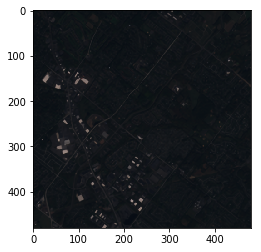

In [7]:
#img = cv2.imread(files[1], cv2.IMREAD_UNCHANGED)
img = io.imread(files[140])
#img = (img * 255).astype(np.uint8)
#img[img < 0] = 1
#img[img > 10000] = 10000
#img = img.astype(np.float32) / 10000.
#crop_size = 4
#cropped_img = img[crop_size:-crop_size, crop_size:-crop_size, :]

# print(np.max(img), np.min(img))

#img = ((img - np.min(img))/(np.max(img) - np.min(img)) * 255).astype(np.uint8)

#print(fr.ssim(img, img, MAX = 1.)[0])
#print(niqe.niqe(img))

print(np.max(img), np.min(img))
print("image", cropped_img.shape, img.dtype)
plt.imshow(img)
#print(np.finfo(np.float32).max)
#io.imsave("/home/yuxin420/Jing/BasicSR/data/tiff/test/landsat")

In [154]:
#im = Image.open(filenames[0])
#print(im)
#image = skitiff.imread(filenames[0])
image = io.imread(filenames[0])
#image = image[:, :, [2, 1, 0]]
#print(type(image))
#image = image / 10000.
#image = cv2.imread(filenames[5])
#image = image.astype(np.float32) / 10000.

#img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

#image = img
#image 
#io.imsave("/home/yuxin420/Jing/BasicSR/data/tiff/x4/x4_1024_float.tif", image)

print(np.max(image))

print("image", image.shape, image.dtype)
io.imshow(image)
#plt.imshow(image)
#plt.show()

ValueError: invalid TIFF file

In [62]:
d = {'banana': 3, 'apple': 4, 'pear': 1, 'orange': 2}
type(d)

dict

In [67]:
from collections import OrderedDict
od = OrderedDict(sorted(d.items(), key=lambda t: t[0]))
type(od)
print(od.items())
print(od.keys())

odict_items([('apple', 4), ('banana', 3), ('orange', 2), ('pear', 1)])
odict_keys(['apple', 'banana', 'orange', 'pear'])


In [71]:
for k, v in od.items():
    print(k, type(k), v, type(v))

apple <class 'str'> 4 <class 'int'>
banana <class 'str'> 3 <class 'int'>
orange <class 'str'> 2 <class 'int'>
pear <class 'str'> 1 <class 'int'>


In [76]:
od['apple']

4